# Set up

Please see the note.md to have note knowledge.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MNIST

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist.data, mnist.target

In [5]:
type(X[0])

numpy.ndarray

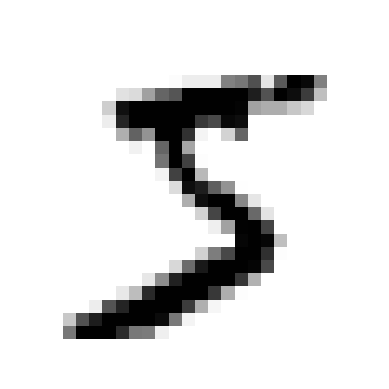

In [6]:
def plot_digit(image_data: np.ndarray):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
y[0]

'5'

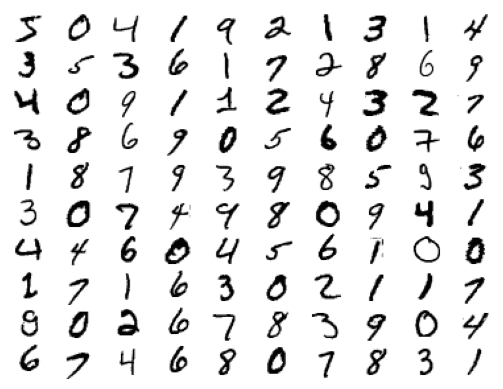

In [8]:
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [9]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [10]:
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

# Training a binary classifier

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# Performance measures

The way we measures performance in classification task is far different from regression task.

## Measure accuracy using cross-validation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [14]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## Confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

In [17]:
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## Precision, recall and $F_1$ score

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # 3530 / (3530 + 687)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)  # 3530 / (3530 + 1891)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## The precision/recall trade off

Typically, the easier you accept a number to be true, the higher the recall but the lower the precision.<br> 
At the two most extreme: 
- If you accept everything to be true, then recall = 1, but precision is very low. 
- If you deny everything to be false but the most confident one, then precision = 1 (very likely), but recall is very low.

The 'easy' described above can be quantitative in sklearn using decision function.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 3000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

We can find the decision_function using method parameter, by `method="decision_function"`

In [23]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

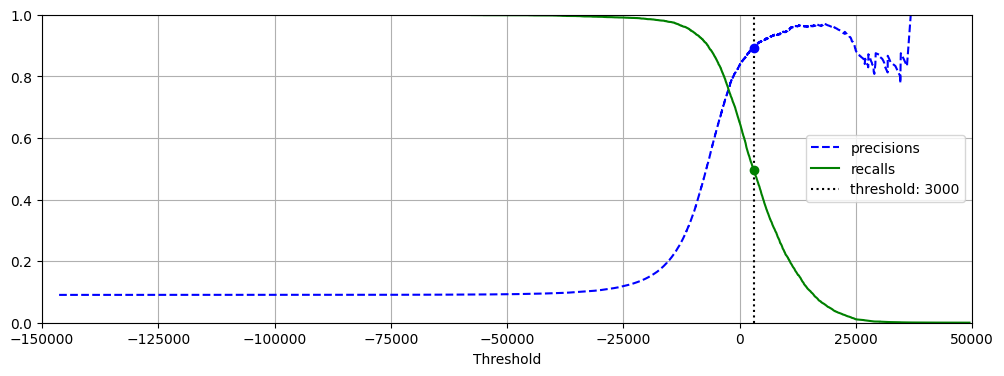

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="precisions")
plt.plot(thresholds, recalls[:-1], "g-", label="recalls")
plt.vlines(threshold, 0, 1, "k", "dotted", label=f"threshold: {threshold}")

threshold_idx = (thresholds >= threshold).argmax()  # first index >= threshold
plt.plot(thresholds[threshold_idx], recalls[threshold_idx], "go")
plt.plot(thresholds[threshold_idx], precisions[threshold_idx], "bo")
plt.axis([-150000, 50000, 0, 1])
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.grid()

plt.show()

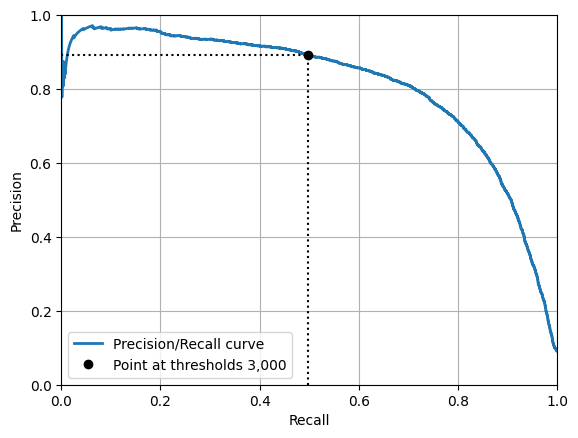

In [26]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot(
    recalls[threshold_idx],
    precisions[threshold_idx],
    "ko",
    label="Point at thresholds 3,000",
)
plt.hlines(precisions[threshold_idx], 0, recalls[threshold_idx], "k", ":")
plt.vlines(recalls[threshold_idx], 0, precisions[threshold_idx], "k", ":")

plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.axis([0, 1, 0, 1])
plt.show()

If you want to find the threshold that has 90% precision, you can do this:

In [27]:
idx_for_90_precision = (precisions > 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

Instead of train again, just simply compare the score against the threshold.

In [28]:
y_train_pred_90 = y_scores > threshold_for_90_precision

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

## The ROC curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

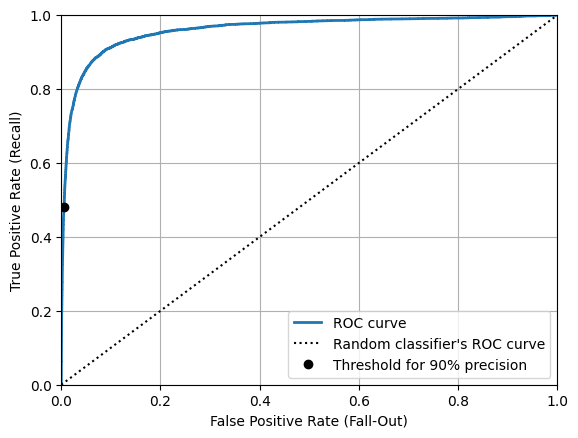

In [32]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate (Recall)")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.grid()
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)

In [35]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

These are *estimated probabilities*, not actual probability, as we can't know the underlying function. In this example, among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positives images.

In [36]:
idx_50_to_60 = (y_probas_forest[:, 1] < 0.60) & (y_probas_forest[:, 1] > 0.50)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [37]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

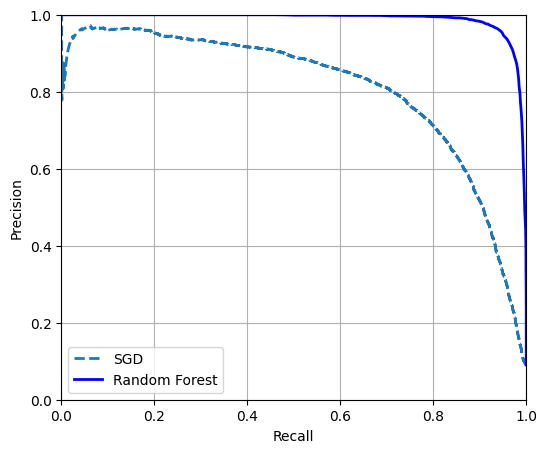

In [38]:
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")

plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower left")

plt.show()

The difference between y_train_pred_forest and y_scores_forest is:
- The former only contains 1 and 0, illustrate Positive and Negative
- The latter contains number in range [0, 1], illustrate the estimated possibility

In [39]:
y_train_pred_forest = y_probas_forest[:, 1] > 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9242275142688446

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification 

In [43]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [44]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [46]:
class_id = some_digit_scores.argmax()
class_id

5

In [47]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [48]:
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [49]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [50]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [51]:
len(ovr_clf.estimators_)

10

In [52]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [53]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error analysis

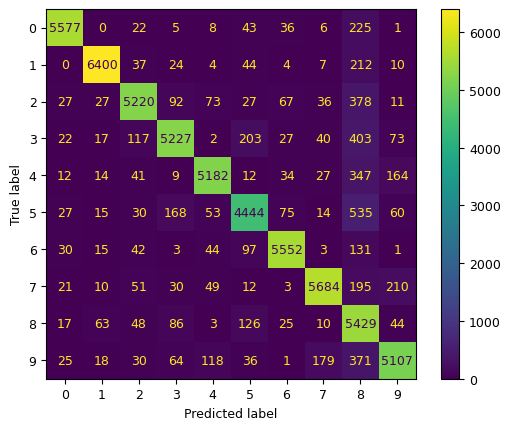

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

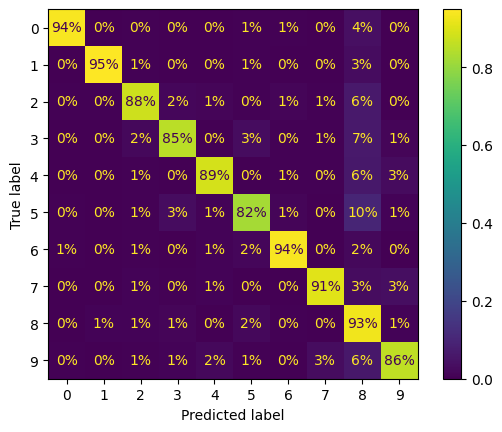

In [57]:
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred, normalize="true", values_format=".0%"
)
plt.show()

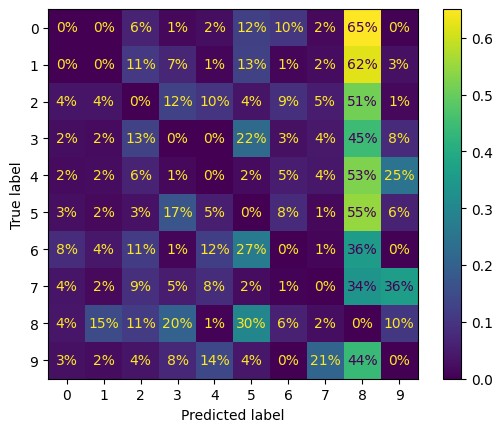

In [58]:
sample_weight = y_train != y_train_pred
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight=sample_weight,
    normalize="true",
    values_format=".0%",
)
plt.show()

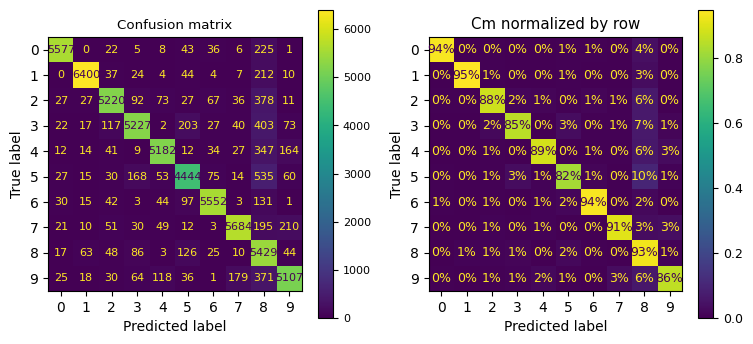

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc("font", size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred, ax=axs[1], normalize="true", values_format=".0%"
)
axs[1].set_title("Cm normalized by row")
plt.show()

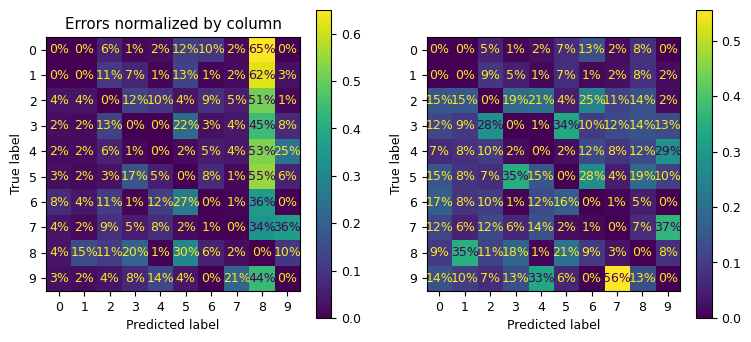

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight=sample_weight,
    ax=axs[0],
    normalize="true",
    values_format=".0%",
)
axs[0].set_title("Errors normalized by row")
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight=sample_weight,
    ax=axs[1],
    normalize="pred",
    values_format=".0%",
)
axs[0].set_title("Errors normalized by column")
plt.show()
plt.rc("font", size=14)

In [61]:
cl_a, cl_b = "3", "5"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

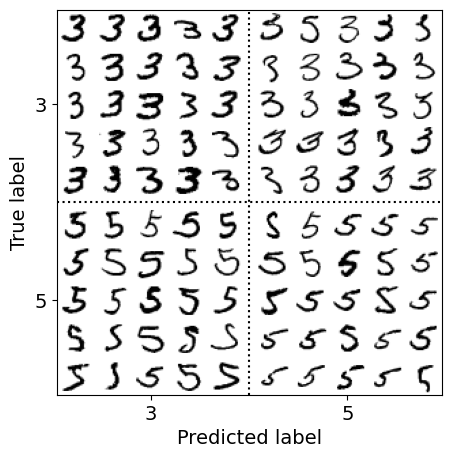

In [62]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [
    (X_ba, (0, 0)),
    (X_bb, (1, 0)),
    (X_aa, (0, 1)),
    (X_ab, (1, 1)),
]:
    for idx, image_data in enumerate(images[: size * size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(
            image_data.reshape(28, 28), cmap="binary", extent=(x, x + 1, y, y + 1)
        )
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Multilabel classification

In [63]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= "7"
y_train_odd = y_train.astype("int8") % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [66]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [67]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput classification

In [70]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

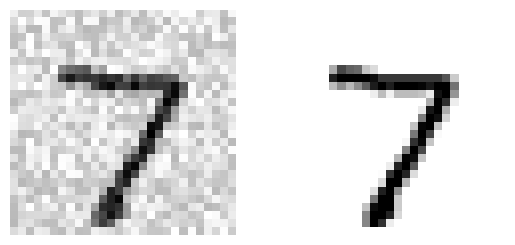

In [71]:
plt.subplot(121), plot_digit(X_test_mod[0])
plt.subplot(122), plot_digit(y_test_mod[0])
plt.show()

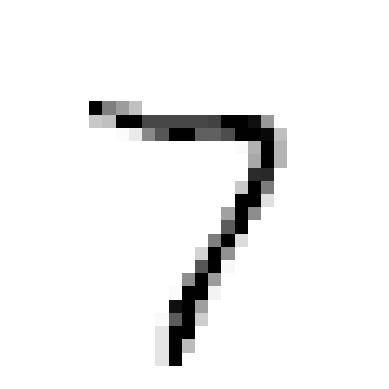

In [73]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()